In [1]:
# https://www.kaggle.com/haqishen/train-efficientnet-b0-w-36-tiles-256-lb0-87

In [2]:
import os
import sys

In [3]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm

In [4]:
DEBUG=False
data_dir = '../data'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

kernel_type = 'how_to_train_effnet_b0_to_get_LB_0.86'

enet_type = 'efficientnet-b0'
fold = 0
tile_size = 256
image_size = 256
n_tiles = 36
batch_size = 2
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 1 if DEBUG else 30
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

../data/train_images


In [5]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,4
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,2


In [6]:
pretrained_model = {
    'efficientnet-b0': '/home/watts/.torch/models/efficientnet-b0-08094119.pth'
}

In [7]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [8]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


In [9]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
#         print(tiff_file)
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
            
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                    print(this_img.shape)
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [10]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

In [11]:
tiff_file = "../data/train_images/984505f6a79b889bed5897d2135b85b1.tiff"
image = skimage.io.MultiImage(tiff_file)[1]

In [12]:
# image[-1]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 

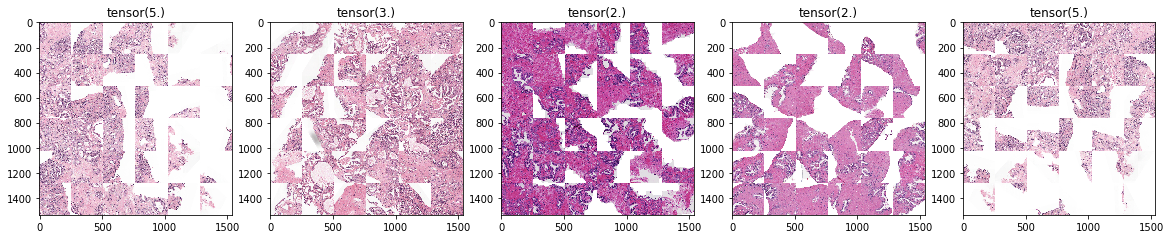

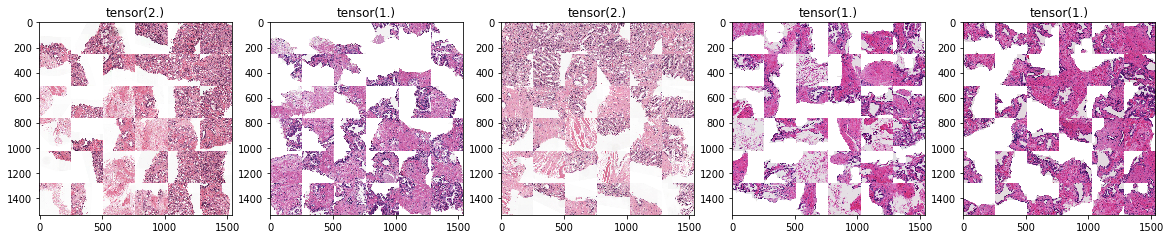

In [13]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))

In [14]:
criterion = nn.BCEWithLogitsLoss()

In [15]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss

In [16]:
def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

In [17]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

8490 2126


In [18]:
qwk_max = 0.
best_file = f'../cache/{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'../cache/{kernel_type}_final_fold{fold}.pth'))

Wed Jun 10 17:15:53 2020 Epoch: 1


/home/watts/anaconda3/envs/panda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



qwk 0.7624855112359872 qwk_k 0.7578074341109455 qwk_r 0.6768851693712871
Wed Jun 10 17:59:10 2020 Epoch 1, lr: 0.0000300, train loss: 0.44263, val loss: 0.30379, acc: 39.36971, qwk: 0.76249
score2 (0.000000 --> 0.762486).  Saving model ...
Wed Jun 10 17:59:10 2020 Epoch: 2



qwk 0.7836344159506572 qwk_k 0.7936712814800407 qwk_r 0.7147793061988477
Wed Jun 10 18:42:30 2020 Epoch 2, lr: 0.0003000, train loss: 0.37278, val loss: 0.30888, acc: 47.17780, qwk: 0.78363
score2 (0.762486 --> 0.783634).  Saving model ...
Wed Jun 10 18:42:30 2020 Epoch: 3



qwk 0.8264666764387085 qwk_k 0.8242574246256382 qwk_r 0.7835585295407954
Wed Jun 10 19:25:49 2020 Epoch 3, lr: 0.0000300, train loss: 0.26739, val loss: 0.26149, acc: 58.18438, qwk: 0.82647
score2 (0.783634 --> 0.826467).  Saving model ...
Wed Jun 10 19:25:49 2020 Epoch: 4



qwk 0.7823410257778582 qwk_k 0.7972910326869342 qwk_r 0.703693681816557
Wed Jun 10 20:09:56 2020 Epoch 4, lr: 0.0002965, train loss: 0.30303, val loss: 0.28054, acc: 50.32926, qwk: 0.78234
Wed Jun 10 20:09:56 2020 Epoch: 5



qwk 0.8063105572175866 qwk_k 0.8088876675761085 qwk_r 0.7565515692164768
Wed Jun 10 20:54:07 2020 Epoch 5, lr: 0.0002921, train loss: 0.28032, val loss: 0.30904, acc: 56.53810, qwk: 0.80631
Wed Jun 10 20:54:07 2020 Epoch: 6



qwk 0.7693323343513345 qwk_k 0.7751639937403634 qwk_r 0.7071228403740923
Wed Jun 10 21:38:36 2020 Epoch 6, lr: 0.0002861, train loss: 0.26413, val loss: 0.30840, acc: 55.73848, qwk: 0.76933
Wed Jun 10 21:38:36 2020 Epoch: 7



qwk 0.8472897710193104 qwk_k 0.8611217291376634 qwk_r 0.8013412541026976
Wed Jun 10 22:21:50 2020 Epoch 7, lr: 0.0002785, train loss: 0.25134, val loss: 0.25685, acc: 61.24177, qwk: 0.84729
score2 (0.826467 --> 0.847290).  Saving model ...
Wed Jun 10 22:21:50 2020 Epoch: 8



qwk 0.8174736725799154 qwk_k 0.8165239195995809 qwk_r 0.7731935733849538
Wed Jun 10 23:05:06 2020 Epoch 8, lr: 0.0002694, train loss: 0.24103, val loss: 0.27747, acc: 59.73659, qwk: 0.81747
Wed Jun 10 23:05:06 2020 Epoch: 9



qwk 0.7906085940346368 qwk_k 0.8298775356870984 qwk_r 0.7117578600079042
Wed Jun 10 23:48:23 2020 Epoch 9, lr: 0.0002589, train loss: 0.23394, val loss: 0.28127, acc: 54.65663, qwk: 0.79061
Wed Jun 10 23:48:23 2020 Epoch: 10



qwk 0.789850670244399 qwk_k 0.8167123435997911 qwk_r 0.7284199538215874
Thu Jun 11 00:31:37 2020 Epoch 10, lr: 0.0002471, train loss: 0.22436, val loss: 0.30040, acc: 58.79586, qwk: 0.78985
Thu Jun 11 00:31:37 2020 Epoch: 11



qwk 0.8419731935369684 qwk_k 0.8358296170862058 qwk_r 0.7988044429394745
Thu Jun 11 01:14:52 2020 Epoch 11, lr: 0.0002342, train loss: 0.21870, val loss: 0.24435, acc: 61.10066, qwk: 0.84197
Thu Jun 11 01:14:52 2020 Epoch: 12



qwk 0.8421091719272187 qwk_k 0.8642979766144216 qwk_r 0.7906138563144198
Thu Jun 11 01:58:05 2020 Epoch 12, lr: 0.0002203, train loss: 0.21215, val loss: 0.25133, acc: 62.98213, qwk: 0.84211
Thu Jun 11 01:58:05 2020 Epoch: 13



qwk 0.8538280569412644 qwk_k 0.872588565452052 qwk_r 0.7986370922882094
Thu Jun 11 02:41:19 2020 Epoch 13, lr: 0.0002055, train loss: 0.20133, val loss: 0.24297, acc: 62.13547, qwk: 0.85383
score2 (0.847290 --> 0.853828).  Saving model ...
Thu Jun 11 02:41:20 2020 Epoch: 14



qwk 0.8419171849317819 qwk_k 0.8619281814994741 qwk_r 0.7926649511579684
Thu Jun 11 03:24:33 2020 Epoch 14, lr: 0.0001901, train loss: 0.19482, val loss: 0.27404, acc: 63.68768, qwk: 0.84192
Thu Jun 11 03:24:33 2020 Epoch: 15



qwk 0.8586670565670713 qwk_k 0.8806804950387063 qwk_r 0.8055610379509868
Thu Jun 11 04:07:47 2020 Epoch 15, lr: 0.0001743, train loss: 0.18633, val loss: 0.23887, acc: 64.20508, qwk: 0.85867
score2 (0.853828 --> 0.858667).  Saving model ...
Thu Jun 11 04:07:47 2020 Epoch: 16



qwk 0.846816592051786 qwk_k 0.8411767766659265 qwk_r 0.812173182597739
Thu Jun 11 04:51:01 2020 Epoch 16, lr: 0.0001581, train loss: 0.18308, val loss: 0.26054, acc: 55.59737, qwk: 0.84682
Thu Jun 11 04:51:01 2020 Epoch: 17



qwk 0.8417957166318684 qwk_k 0.8722361827635953 qwk_r 0.7832941408203603
Thu Jun 11 05:34:12 2020 Epoch 17, lr: 0.0001419, train loss: 0.17312, val loss: 0.27234, acc: 65.61618, qwk: 0.84180
Thu Jun 11 05:34:12 2020 Epoch: 18



qwk 0.8562179425203702 qwk_k 0.881896436805472 qwk_r 0.8040340349005732
Thu Jun 11 06:17:29 2020 Epoch 18, lr: 0.0001257, train loss: 0.16705, val loss: 0.24460, acc: 67.30950, qwk: 0.85622
Thu Jun 11 06:17:29 2020 Epoch: 19



qwk 0.8634896993624899 qwk_k 0.8927935058814906 qwk_r 0.8063597723330972
Thu Jun 11 07:00:47 2020 Epoch 19, lr: 0.0001099, train loss: 0.15826, val loss: 0.24811, acc: 64.44026, qwk: 0.86349
score2 (0.858667 --> 0.863490).  Saving model ...
Thu Jun 11 07:00:47 2020 Epoch: 20



qwk 0.8589383824066299 qwk_k 0.8834550382486213 qwk_r 0.8073327964302937
Thu Jun 11 07:44:01 2020 Epoch 20, lr: 0.0000945, train loss: 0.15353, val loss: 0.25495, acc: 65.47507, qwk: 0.85894
Thu Jun 11 07:44:01 2020 Epoch: 21



qwk 0.8589492688775167 qwk_k 0.8908780961838502 qwk_r 0.8039188686454163
Thu Jun 11 08:27:16 2020 Epoch 21, lr: 0.0000797, train loss: 0.14812, val loss: 0.27040, acc: 66.74506, qwk: 0.85895
Thu Jun 11 08:27:16 2020 Epoch: 22



qwk 0.8581940050247714 qwk_k 0.8901083314789358 qwk_r 0.799166229473754
Thu Jun 11 09:10:29 2020 Epoch 22, lr: 0.0000658, train loss: 0.13824, val loss: 0.25713, acc: 65.14581, qwk: 0.85819
Thu Jun 11 09:10:29 2020 Epoch: 23



qwk 0.8637890848135095 qwk_k 0.890928122674615 qwk_r 0.809855653230142
Thu Jun 11 09:53:42 2020 Epoch 23, lr: 0.0000529, train loss: 0.13520, val loss: 0.25996, acc: 66.36877, qwk: 0.86379
score2 (0.863490 --> 0.863789).  Saving model ...
Thu Jun 11 09:53:43 2020 Epoch: 24



qwk 0.8561087376611934 qwk_k 0.8820014893864738 qwk_r 0.8013271690463343
Thu Jun 11 10:36:58 2020 Epoch 24, lr: 0.0000411, train loss: 0.13109, val loss: 0.25642, acc: 66.79210, qwk: 0.85611
Thu Jun 11 10:36:58 2020 Epoch: 25



qwk 0.868555567527174 qwk_k 0.8960527178961937 qwk_r 0.816290207835764
Thu Jun 11 11:20:10 2020 Epoch 25, lr: 0.0000306, train loss: 0.12399, val loss: 0.24662, acc: 66.55691, qwk: 0.86856
score2 (0.863789 --> 0.868556).  Saving model ...
Thu Jun 11 11:20:10 2020 Epoch: 26



qwk 0.8660649135135148 qwk_k 0.8894070183636514 qwk_r 0.8150951918433745
Thu Jun 11 12:03:25 2020 Epoch 26, lr: 0.0000215, train loss: 0.11980, val loss: 0.26166, acc: 65.75729, qwk: 0.86606
Thu Jun 11 12:03:25 2020 Epoch: 27



qwk 0.8622664917334757 qwk_k 0.8879965576665049 qwk_r 0.8093786315790129
Thu Jun 11 12:46:40 2020 Epoch 27, lr: 0.0000139, train loss: 0.11945, val loss: 0.25678, acc: 65.99247, qwk: 0.86227
Thu Jun 11 12:46:40 2020 Epoch: 28



qwk 0.8661261091705162 qwk_k 0.8932930599879894 qwk_r 0.8140060631064902
Thu Jun 11 13:29:55 2020 Epoch 28, lr: 0.0000079, train loss: 0.11746, val loss: 0.25577, acc: 67.02728, qwk: 0.86613
Thu Jun 11 13:29:55 2020 Epoch: 29



qwk 0.8684006658158143 qwk_k 0.8957702082060754 qwk_r 0.8159092277754831
Thu Jun 11 14:13:13 2020 Epoch 29, lr: 0.0000035, train loss: 0.11580, val loss: 0.25542, acc: 66.74506, qwk: 0.86840
Thu Jun 11 14:13:13 2020 Epoch: 30



qwk 0.8678765680409126 qwk_k 0.8968726368674573 qwk_r 0.8135161587102506
Thu Jun 11 14:56:32 2020 Epoch 30, lr: 0.0000009, train loss: 0.11415, val loss: 0.25589, acc: 66.41580, qwk: 0.86788
